<a href="https://colab.research.google.com/github/mukhairatil/ABSA_BRIMO_GooglePlaystore_IndoRoBERTa/blob/main/absa_brimo_indoroberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install google-play-scraper pandas

In [7]:
# Import Library
from google_play_scraper import reviews, Sort
import pandas as pd
from datetime import datetime

# ID Aplikasi BRImo
app_id = "id.co.bri.brimo"

# periode waktu
start_date = datetime(2025, 6, 24)
end_date   = datetime(2025, 12, 24)

all_reviews = []
continuation_token = None

# Loop untuk mengambil Semua Review Dalam Periode
while True:
    result, continuation_token = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=200,
        continuation_token=continuation_token
    )

    if not result:
        break

    for review in result:
        review_date = review['at']

        # Lewati jika lebih baru dari end_date
        if review_date > end_date:
            continue

        # Jika sudah lebih lama dari start_date, hentikan total loop
        if review_date < start_date:
            break

        all_reviews.append(review)

    # Jika data terakhir sudah melewati start_date → stop
    if result[-1]['at'] < start_date:
        break

In [8]:
#mengubah ke dataframe
df = pd.DataFrame(all_reviews)

print("Total review dalam periode:", len(df))
print("Tanggal terlama:", df['at'].min())
print("Tanggal terbaru:", df['at'].max())

Total review dalam periode: 55456
Tanggal terlama: 2025-06-24 00:00:01
Tanggal terbaru: 2025-12-23 23:58:50


In [9]:
df_5000 = df.sample(n=5000, random_state=42)

print("Jumlah data setelah sampling:", len(df_5000))

Jumlah data setelah sampling: 5000


In [10]:
df_5000.to_csv("5000ulasan_brimo_24Juni_24Desember_2025.csv",index=False, encoding='utf-8-sig')

print("File berhasil disimpan!" )

File berhasil disimpan!


In [11]:
print("Jumlah data:", len(df_5000))
df_5000.head()

Jumlah data: 5000


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
21232,90b73aad-6ce6-4ea6-834a-97ad38fae266,AHS Story,https://play-lh.googleusercontent.com/a-/ALV-U...,"aplikasi di samsung a23 tidak bisa dibuka, ket...",1,1,2.87.1,2025-09-18 13:22:42,"Hai Sobat BRI, mohon maaf atas kendala yang di...",2025-09-17 09:27:31,2.87.1
49719,08561b07-d6e3-4892-afd1-63e6f62c56e3,Mas Budi,https://play-lh.googleusercontent.com/a/ACg8oc...,mantap,5,0,2.84.0,2025-07-04 06:12:54,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-07-04 06:36:01,2.84.0
27791,e48d5618-ea26-4000-aef0-ccb04ea14572,kiky Irawan,https://play-lh.googleusercontent.com/a/ACg8oc...,Bagus dapat membantu,5,0,2.80.0,2025-08-30 03:07:02,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-08-30 03:42:29,2.80.0
4800,d1360668-fcd6-410f-a124-63dfe0f78406,Rizqi S,https://play-lh.googleusercontent.com/a-/ALV-U...,tolong lah tolong inimah jangan malah batasi s...,1,2,2.90.0,2025-12-01 13:46:43,"Hai Sobat BRI, mohon maaf atas kendala yang di...",2025-12-01 18:34:57,2.90.0
36045,d55ea81f-bd7c-476b-8b26-08559b5f48ff,Husen Fahrur,https://play-lh.googleusercontent.com/a/ACg8oc...,transaksi cepat,5,0,2.86.0,2025-08-09 05:46:35,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-08-09 05:59:47,2.86.0


In [18]:
df = df.sample(n=5000, random_state=42).reset_index(drop=True)

print("Jumlah data:", len(df))

df['score'].value_counts().sort_index()

Jumlah data: 5000


,count
score,
1,615
2,125
3,143
4,277
5,3840


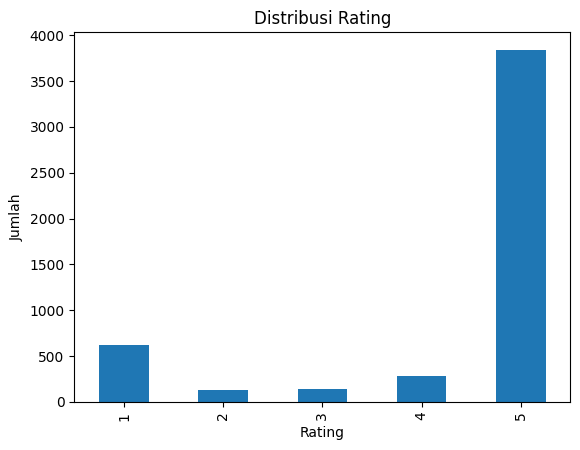

In [20]:
import matplotlib.pyplot as plt

df['score'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribusi Rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

In [21]:
def label_sentiment(score):
    if score <= 2:
        return "negatif"
    elif score == 3:
        return "netral"
    else:
        return "positif"

df['sentiment'] = df['score'].apply(label_sentiment)

df['sentiment'].value_counts()

,count
sentiment,
positif,4117
negatif,740
netral,143


In [22]:
df['clean_text'] = df['content'].str.lower()

In [23]:
#menghapus url,angka,simbol dan missing value
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['clean_text'] = df['clean_text'].apply(clean_text)
df = df.dropna(subset=['clean_text'])

In [25]:
#mengidentifikasi aspek menggunakan aspect category classification.
aspects = {
    "login" : ["login","masuk","otp"],
    "performa": ["error","lambat","bug","gagal","loading"],
    "fitur": ["transfer","top up","qris","transaksi"],
    "keamanan": ["aman","otp","verifikasi","password"],
    "kemudahan": ["mudah","ribet","sulit","user friendly"],
    "layanan": ["cs","customer service","respon"]
}

def detect_aspect(text):
    for aspect, keywords in aspects.items():
        for keyword in keywords:
            if keyword in text:
                return aspect
    return "lainnya"

df['aspect'] = df['clean_text'].apply(detect_aspect)

df['aspect'].value_counts()

,count
aspect,
lainnya,3439
kemudahan,521
fitur,507
login,223
keamanan,176
performa,120
layanan,14
